In [48]:
from itertools import islice

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv 

In [2]:
semgroups = "/kaggle/input/thesis/SemGroups_2018.txt"
semtypes = "/kaggle/input/thesis/SemanticTypes_2018AB.txt"
medmentions = "/kaggle/input/thesis/corpus_pubtator.txt"
umls_concept = "/kaggle/input/thesis/MRCONSO.RRF"
train_docs_ids = "../input/doc-ids/corpus_pubtator_pmids_trng.txt"
val_docs_ids = "../input/doc-ids/corpus_pubtator_pmids_dev.txt"
test_docs_ids = "../input/doc-ids/corpus_pubtator_pmids_test.txt"

In [3]:
def read_in_chunks(file_object, n=10000):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = list(islice(file_object, n))
        if not data:
            break
        yield data
        
def umls_concepts():
    umls_concepts = {}
    with open(umls_concept) as f:
        for piece in read_in_chunks(f):
            for line in piece:
                if line != "":
                    line_list = line.split("|")
                    if line_list[1] == 'ENG':
                        umls_concepts[line_list[0]] = line_list[14]
    return umls_concepts

def umls_semtype():
    umls_semtype = {}
    with open(semgroups) as f:
        f = f.read().split("\n")
        for line in f:
            if line != "":
                line_list = line.split("|")
                umls_semtype[line_list[2]] = [line_list[1], line_list[3]]
    return umls_semtype

In [4]:
umls_concepts = umls_concepts()
umls_semtype = umls_semtype()

umls_semtype['T131']

['Chemicals & Drugs', 'Hazardous or Poisonous Substance']

In [5]:
len(umls_concepts), len(umls_semtype)

(4412440, 127)

## Build Data

In [6]:
%%capture
!pip install git+https://github.com/ArshSekhon/pubtator_loader.git

from pubtator_loader import PubTatorCorpusReader
dataset_reader = PubTatorCorpusReader(medmentions)

corpus = dataset_reader.load_corpus() 

In [64]:
def build_data():
    sequences = []
    label_codes = []
    labels = []
    articles_ids = []
    entire_corpus = []
    full_maps = []
    for doc in corpus:
        row = []
        umls_map = []
        full_text = doc.get_space_separated_title_and_abstract()
        entire_corpus.append(full_text)
        full_text_replaced = full_text
        for i, ent in enumerate(doc.entities):
            umls_concept_code = ent.entity_id
            text_segment = ent.text_segment
            full_text_replaced = full_text_replaced.replace(text_segment, " "+umls_concept_code+" ", 1)
            umls_map.append([text_segment, umls_concept_code])
            
        full_maps.append(umls_map)
        full_text_list = full_text_replaced.split(" ")        
        entities_list = [ent.entity_id for ent in doc.entities]
        articles_ids.append(doc.id)
        
        for word in full_text_list:
            if word != '':
                idx = -1
                indices = [i for i, x in enumerate(entities_list) if x == word]
                if word in entities_list:
                    idx = entities_list.index(word)   
                if idx > -1:
                    if "," in doc.entities[idx].semantic_type_id:
                        sem_ent = doc.entities[idx].semantic_type_id.split(",")[0]
                    else:
                        sem_ent = doc.entities[idx].semantic_type_id
                    
                    
                    extracted_entity = umls_semtype.get(sem_ent)
                    
                    if extracted_entity is not None:
                        entity = extracted_entity[1] 
                    else:
                        if sem_ent == "UnknownType":
                            entity = "UnknownType"
                        else:
                            entity = 'o'
                    row.append([word, sem_ent, entity])
                else:
                    row.append([word, 'o', 'o'])
                    
        sequences.append(list(np.array(row)[:,0]))
        label_codes.append(list(np.array(row)[:,1]))
        labels.append(list(np.array(row)[:,2]))
    
    original_text_list = sequences
    original_text = []
    for i, text in enumerate(original_text_list):
        text_string = "|i|".join(text)
        for k, v in full_maps[i]:
            text_string = text_string.replace(v, k, 1)
        text_string_list = text_string.split("|i|")
        original_text.append(text_string_list)
    
    return sequences, label_codes, labels, entire_corpus, articles_ids, original_text
    
sequences, label_codes, labels, entire_corpus, articles_ids, original_text = build_data()

In [65]:
assert sequences[0][0] == "C4308010"
assert label_codes[0][0] == "T116"
assert sequences[0][-5] == "C0854135"
assert label_codes[0][-5] == "T047"

assert sequences[5][1] == "C0870811"
assert label_codes[5][1] == "T054"
assert sequences[5][-2] == "C0243095"
assert label_codes[5][-2] == "T033"

text_0 = """DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been included, all of them carrying two CFTR defects: 103 developed at least 1 pulmonary infection with Pa, and 68 patients of them had CPA. DCTN4 variants were identified in 24% (29/121) CF patients with Pa infection and in only 17% (3/18) CF patients with no Pa infection. Of the patients with CPA, 29% (20/68) had DCTN4 missense variants vs 23% (8/35) in patients without CPA. Interestingly, p.Tyr263Cys tend to be more frequently observed in CF patients with CPA than in patients without CPA (4/68 vs 0/35), and DCTN4 missense variants tend to be more frequent in male CF patients with CPA bearing two class II mutations than in male CF patients without CPA bearing two class II mutations (P = 0.06). Our observations reinforce that DCTN4 missense variants, especially p.Tyr263Cys, may be involved in the pathogenesis of CPA in male CF."""
sequences_codes_3 = ["C0277814", "C0806909", "C0231452", ":", "An", "C1523987", "to", "C0231472", "C0806909", "C0231452", "for", "determining", "presence"]
labels_3 = ["T033", "T081", "T042", "o", "o", "T077", "o", "T082", "T081", "T042", "o", "o", "o"]

assert entire_corpus[0] == text_0
assert sequences[3][:13] == sequences_codes_3
assert label_codes[3][:13] == labels_3

## Data Visualization

In [62]:
#first article
entire_corpus[0]

'DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been included, all of them car

In [66]:
def tokens_tags(data_X, data_y):
    vocab = []
    tags = []
    for seq in data_X:
        for word in np.unique(seq):
            if word.lower() not in vocab:
                vocab.append(word.lower())
    for seq_ent in data_y:
        for ent in seq_ent:
            if ent not in tags:
                tags.append(ent)
                
    return len(vocab), len(tags), max([len(s) for s in sequences])

num_tokens, num_tags, maxlen = tokens_tags(sequences, label_codes)
print('Number of unique tokens ', num_tokens)
print('Max length of sequence ', maxlen)
print('Number of unique tags ', num_tags)

Number of unique tokens  66317
Max length of sequence  685
Number of unique tags  127


In [70]:
def count(entities):
    class_count = {}
    for seq_tags in entities:
        for tag in seq_tags:
            if tag not in class_count.keys():
                class_count[tag] = 1
            else:
                class_count[tag] += 1

    return class_count

class_count = count(label_codes)
class_count

{'T116': 14893,
 'o': 618253,
 'T047': 11689,
 'T101': 6285,
 'T079': 10162,
 'T169': 23630,
 'T033': 15623,
 'T081': 19962,
 'T063': 920,
 'T052': 7245,
 'T062': 8817,
 'T032': 3727,
 'T098': 6304,
 'T100': 2153,
 'T073': 3609,
 'T026': 1592,
 'T028': 4535,
 'T007': 2049,
 'T045': 3427,
 'T046': 3954,
 'T131': 580,
 'T043': 3082,
 'T025': 5516,
 'T067': 2027,
 'T069': 190,
 'T167': 1759,
 'T037': 1885,
 'T001': 1036,
 'T031': 1251,
 'T080': 31423,
 'T121': 3927,
 'T044': 3459,
 'T077': 2993,
 'T082': 7564,
 'T103': 289,
 'T078': 9335,
 'T039': 1305,
 'T109': 10252,
 'T074': 2379,
 'T058': 5675,
 'T070': 2818,
 'T057': 890,
 'T023': 6297,
 'T059': 5080,
 'T042': 1692,
 'T060': 4070,
 'T184': 1885,
 'T024': 1580,
 'T029': 1151,
 'T053': 447,
 'T061': 11400,
 'T083': 3002,
 'T055': 1010,
 'T185': 1391,
 'UnknownType': 2465,
 'T054': 980,
 'T170': 9186,
 'T097': 1854,
 'T093': 601,
 'T041': 3231,
 'T095': 19,
 'T099': 814,
 'T048': 2280,
 'T071': 109,
 'T204': 1791,
 'T168': 1367,
 'T019'

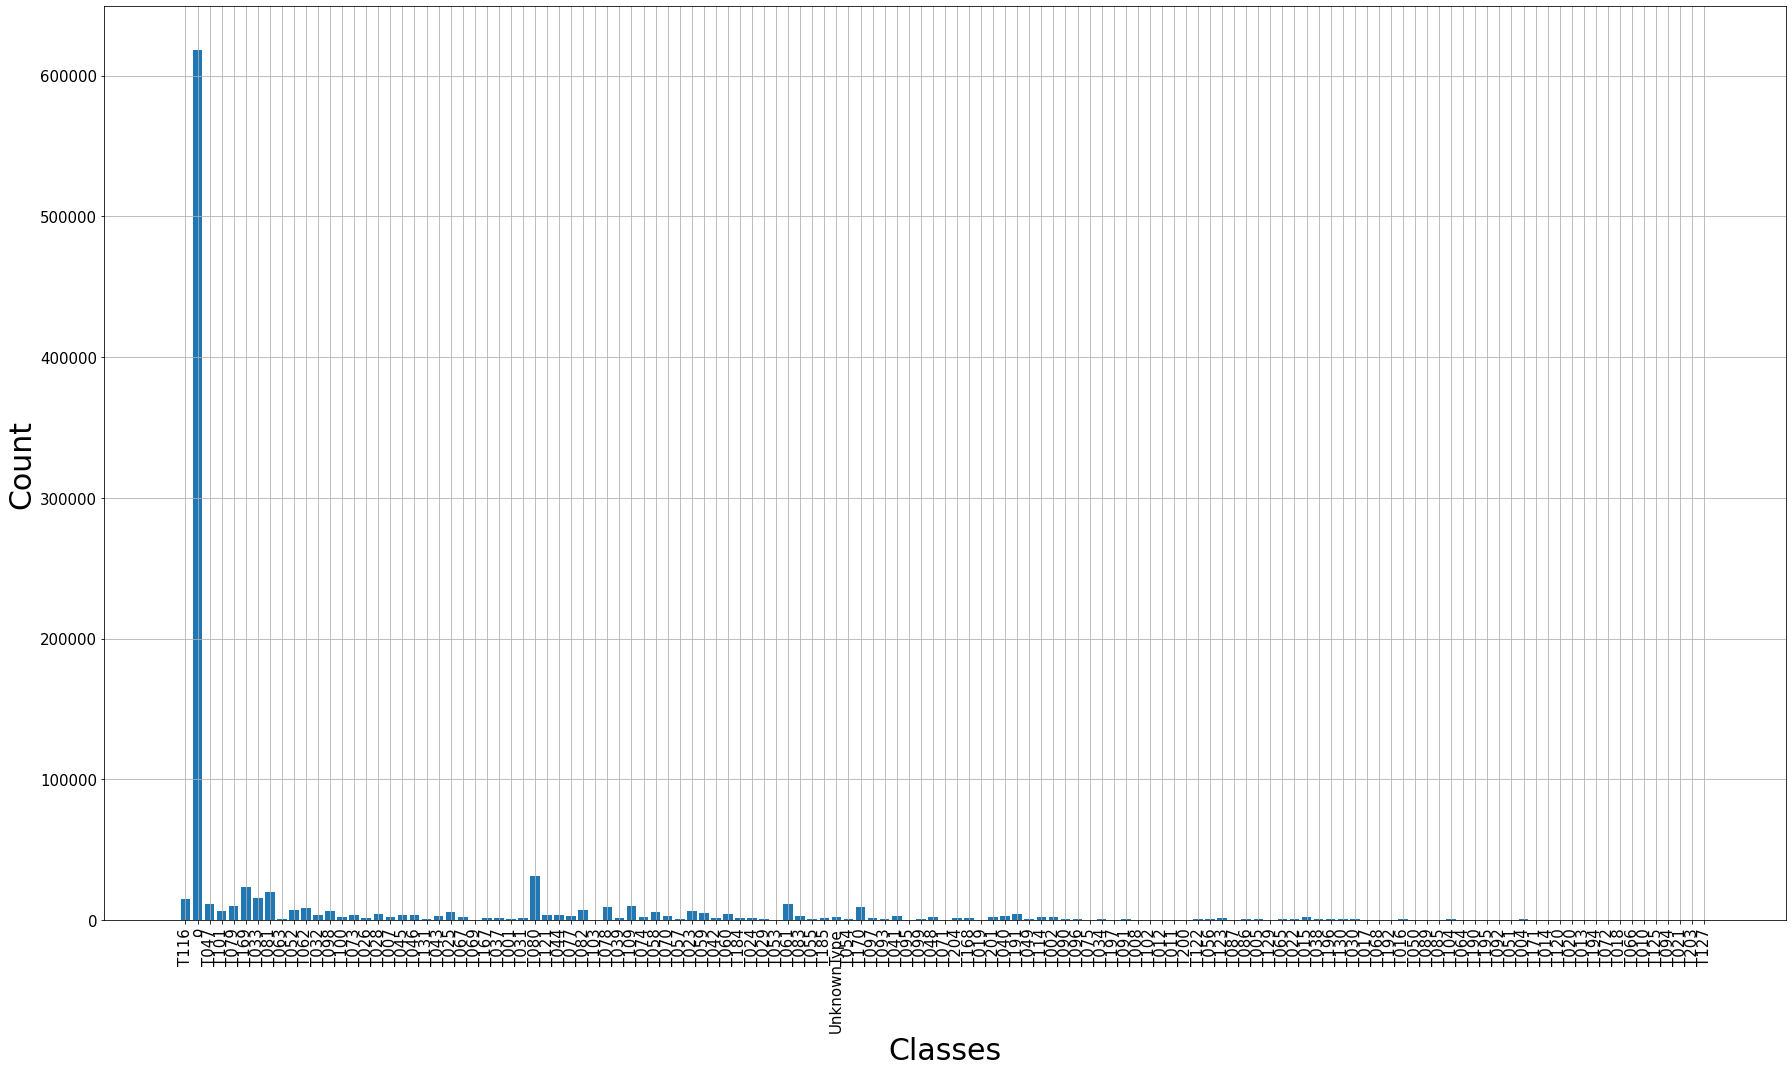

In [77]:
keys = class_count.keys()

values = class_count.values()

plt.figure(figsize=(25,15))
plt.bar(keys, values)    
plt.xlabel('Classes', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

## Train Test Val split

In [78]:
def train_test_val_split():
    train_sequences, test_sequences, val_sequences = [], [], []
    train_labels, test_labels, val_labels = [], [], []
    train_text, test_text, val_text = [], [], []
    train_original_sequences, test_original_sequences ,val_original_sequences = [], [], []
    train_label_codes, test_label_codes, val_label_codes, = [], [], []
    with open(train_docs_ids) as train_ids:
        train_id_list = []
        train_ids = train_ids.read().split("\n")
        for line in train_ids:
            train_id_list.append(line)
    
    with open(val_docs_ids) as val_ids:
        val_id_list = []
        val_ids = val_ids.read().split("\n")
        for line in val_ids:
            val_id_list.append(line)

    with open(test_docs_ids) as test_ids:
        test_id_list = []
        test_ids = test_ids.read().split("\n")
        for line in test_ids:
            test_id_list.append(line)


    for x, y_code, y, txt, idx, ox in zip(sequences, label_codes, labels, entire_corpus, articles_ids, original_text):
        idx = str(idx)
        if idx in train_id_list:
            train_text.append(txt)
            train_sequences.append(x)
            train_labels.append(y)
            train_label_codes.append(y_code)
            train_original_sequences.append(ox)
        elif idx in val_id_list:
            val_text.append(txt)
            val_sequences.append(x)
            val_labels.append(y)
            val_label_codes.append(y_code)
            val_original_sequences.append(ox)
        elif idx in test_id_list:
            test_text.append(txt)
            test_sequences.append(x)
            test_labels.append(y)
            test_label_codes.append(y_code)
            test_original_sequences.append(ox)
            
    return (train_sequences, 
            train_labels, 
            train_label_codes,
            train_text,
            train_original_sequences,
            val_sequences, 
            val_labels,
            val_label_codes,
            val_text, 
            val_original_sequences,
            test_sequences,
            test_labels,
            test_label_codes,
            test_text,
            test_original_sequences)


(train_sequences, 
 train_labels, 
 train_label_codes,
 train_text,
 train_original_sequences,
 val_sequences, 
 val_labels,
 val_label_codes,
 val_text, 
 val_original_sequences,
 test_sequences,
 test_labels,
 test_label_codes,
 test_text,
 test_original_sequences) = train_test_val_split()

In [79]:
print(len(train_sequences))
print(len(train_labels))
print(len(train_text))  
print(len(val_sequences))
print(len(val_labels))
print(len(val_text)) 
print(len(test_sequences))
print(len(test_labels))
print(len(test_text))

2635
2635
2635
878
878
878
879
879
879


In [80]:
num_tokens_train, num_tags_train = tokens_tags(train_sequences, train_labels)[:2]
print('Number of unique tokens in train data ', num_tokens_train)
print('Number of unique tags in train data ', num_tags_train)
num_tokens_val, num_tags_val = tokens_tags(val_sequences, val_labels)[:2]
print('Number of unique tokens in val data ', num_tokens_val)
print('Number of unique tags in val data ', num_tags_val)
num_tokens_test, num_tags_test = tokens_tags(test_sequences, test_labels)[:2]
print('Number of unique tokens in test data ', num_tokens_test)
print('Number of unique tags in test data ', num_tags_test)

Number of unique tokens in train data  48187
Number of unique tags in train data  127
Number of unique tokens in val data  23181
Number of unique tags in val data  125
Number of unique tokens in test data  23252
Number of unique tags in test data  124


## Save all data to csv

In [82]:
def extract_rows(text, seqs, label_codes, labels, otext):
    rows = []
    for txt, x, ox, y_code, y in zip(text, seqs, otext, label_codes, labels):
        rows.append([txt, x, ox, y_code, y])
    return rows

test_rows = extract_rows(test_text, test_sequences, test_label_codes, test_labels, test_original_sequences)
train_rows = extract_rows(train_text, train_sequences, train_label_codes, train_labels, train_original_sequences)
val_rows = extract_rows(val_text, val_sequences, val_label_codes, val_labels, val_original_sequences)

In [83]:
def save_csv(rows, name):
    # field names 
    fields = ['Full Text', 'UMLS Text', 'Original Text', 'Entity Codes', 'Entities'] 
    
    with open(name+'.csv', 'w') as f: 
        write = csv.writer(f) 
        write.writerow(fields) 
        write.writerows(rows) 

save_csv(test_rows, 'test')
save_csv(train_rows, 'train')
save_csv(val_rows, 'val')

In [84]:
data = pd.read_csv('./train.csv')
data.head()

,Full Text,UMLS Text,Original Text,Entity Codes,Entities
0,DCTN4 as a modifier of chronic Pseudomonas aer...,"['C4308010', 'as', 'a', 'modifier', 'of', 'C08...","['DCTN4', 'as', 'a', 'modifier', 'of', 'chroni...","['T116', 'o', 'o', 'o', 'o', 'T047', 'o', 'T04...","['Amino Acid, Peptide, or Protein', 'o', 'o', ..."
1,Prevascularized silicon membranes for the enha...,"['C0042382', 'C0037114', 'C1706182', 'for', 't...","['Prevascularized', 'silicon', 'membranes', 'f...","['T169', 'T109', 'T073', 'o', 'o', 'T052', 'o'...","['Functional Concept', 'Organic Chemical', 'Ma..."
2,Seated maximum flexion: An alternative to stan...,"['C0277814', 'C0806909', 'C0231452', ':', 'An'...","['Seated', 'maximum', 'flexion', ':', 'An', 'a...","['T033', 'T081', 'T042', 'o', 'o', 'T077', 'o'...","['Finding', 'Quantitative Concept', 'Organ or ..."
3,The Relationship Between Distance and Post-ope...,"['The', 'C0439849', 'Between', 'C0012751', 'an...","['The', 'Relationship', 'Between', 'Distance',...","['o', 'T080', 'o', 'T081', 'o', 'T033', 'T053'...","['o', 'Qualitative Concept', 'o', 'Quantitativ..."
4,Promoting lifestyle behaviour change and well-...,"['C0033414', 'C0870811', 'and', 'C0424578', 'i...","['Promoting', 'lifestyle behaviour change', 'a...","['T052', 'T054', 'o', 'T033', 'o', 'T101', 'o'...","['Activity', 'Social Behavior', 'o', 'Finding'..."
